In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json
import scipy.stats as stats
import pandas as pd
import os
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
HOME = os.path.join(os.path.dirname(os.getcwd()), 'results/e2e_profs_new_metrics')
print HOME

/Users/cusgadmin/Desktop/plots-model-comp-paper/results/e2e_profs_new_metrics


In [2]:
from enum import Enum
import unicodedata
        
def cache_extractions(FN):
    with open(FN) as json_data:
        d = json.load(json_data)
    all_metrics = d["client_metrics"][0]["all_metrics"]
    result = {}
    for i in range(len(all_metrics)):
        data_lists = all_metrics[i]["data_lists"]
        for item in data_lists:
            key = item.keys()[0]
            key = unicodedata.normalize('NFKD', key).encode('ascii','ignore')
            if result.get(key) == None:
                result[key] = []
            value = np.asarray(item[key]["items"]).astype(float)
            result[key].append(value)
    batch_sizes = d["client_metrics"][0]["mean_batch_sizes"]
    for i in range(len(all_metrics)):
    for key, value in result.iteritems():
        result[key] = np.concatenate(value)
    str_lats = d["client_metrics"][0]["all_lats"]
    import ast
    lats = [ast.literal_eval(x) for x in str_lats]
    hollistic_data = {}
    hollistic_data["e2e_lats"] = np.asarray(lats).flatten()
    hollistic_data["p99_lats"] = d["client_metrics"][0]["p99_lats"]
    hollistic_data["e2e_thrus"] = d["client_metrics"][0]["thrus"]
    
    return result

image_driver_1_models = [
    "tf-resnet-feats",
    "tf-log-reg",
    "tf-kernel-svm",
    "inception"
]

image_driver_1_500ms_all_1_unsaturated = cache_extractions(HOME+"/"+"incep_1-logreg_1-ksvm_1-resnet_1-180207_210822.json")
# image_driver_1_1000ms_all_1 = cache_extractions(HOME+"/"+"incep_1-logreg_1-ksvm_1-resnet_1-180208_162545.json")
image_driver_1_500ms_all_1 = cache_extractions(HOME+"/"+"incep_1-logreg_1-ksvm_1-resnet_1-180211_044257.json")
# 1/0.0241766984402

# taking off the first 25% of the records to be sure the warmup time is removed
for key, value in image_driver_1_500ms_all_1.iteritems():
    image_driver_1_500ms_all_1[key] = value[value.shape[0]/4:]

for key, value in image_driver_1_500ms_all_1.iteritems():
    print key, value.shape

app:tf-resnet-feats:prediction_latencies (15381,)
app:tf-log-reg:prediction_latencies (14931,)
tf-log-reg:1:queue_sizes (29862,)
inception:processing_latency (12462,)
inception:1:queue_arrivals (15384,)
model:inception:1:prediction_latencies_list (12466,)
tf-resnet-feats:1:queue_sizes (19229,)
model:tf-log-reg:1:prediction_latencies_list (14931,)
app:tf-kernel-svm:prediction_latencies (14875,)
tf-kernel-svm:processing_latency (14876,)
tf-resnet-feats:processing_latency (3849,)
e2e_lats (14850,)
tf-resnet-feats:1:queue_arrivals (15382,)
app:inception:prediction_latencies (15384,)
tf-kernel-svm:1:queue_sizes (29756,)
inception:1:queue_sizes (27839,)
model:tf-resnet-feats:1:prediction_latencies_list (3849,)
tf-log-reg:processing_latency (14931,)
tf-log-reg:1:queue_arrivals (14931,)
tf-kernel-svm:1:queue_arrivals (14878,)
model:tf-kernel-svm:1:prediction_latencies_list (14877,)


In [16]:
def lineHistogram(data, label=None):
    y,binEdges=np.histogram(data)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    plt.plot(bincenters,y,'-', label=label)
    
def compare_latency_dists(cached_extractions, model_list):
    plt.figure(figsize=(5*len(model_list),5))
    for i, model in enumerate(model_list):
        plt.subplot(1, len(model_list), i+1)
        plt.title(model+" Processing Latency")
        plt.xlabel("Time (ms)")
        plt.ylabel("Frequency")
        processing_time = cached_extractions[model+":processing_latency"]
        total_time = cached_extractions["app:"+model+":prediction_latencies"]
        lineHistogram(processing_time, label="Processing time")
        lineHistogram(total_time/1000, label="Processing + Queueing time")
    plt.legend()

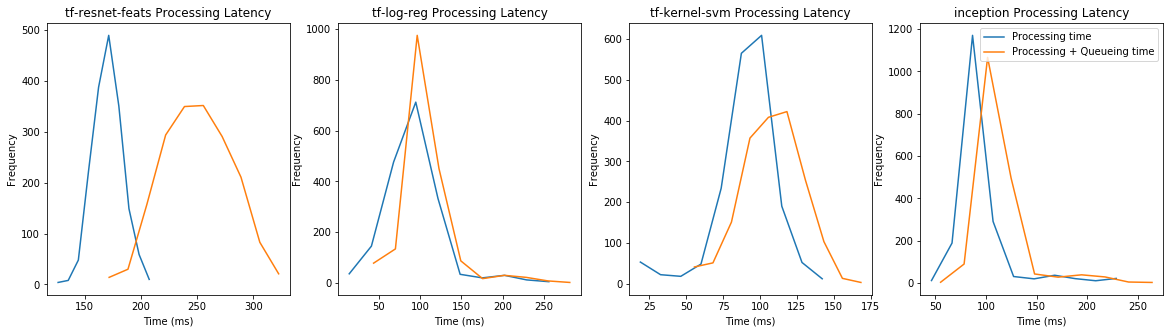

In [17]:
compare_latency_dists(image_driver_1_500ms_all_1_unsaturated, image_driver_1_models)

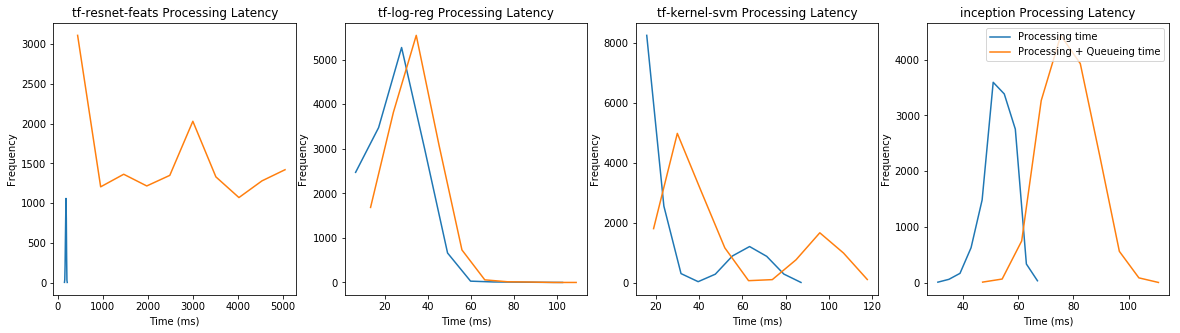

In [18]:
compare_latency_dists(image_driver_1_500ms_all_1, image_driver_1_models)

In [19]:
def plot_inter_arrival(cached_extractions, model_list):
    plt.figure(figsize=(8,8))
    plt.title("Inter-arrival time")
    plt.xlabel("Inter-arrival time (ms)")
    plt.ylabel("Frequency")
    for model in model_list:
        arrivals = cached_extractions[model+":1:queue_arrivals"]
        intervals = arrivals[1:] - arrivals[:-1]
        lineHistogram(intervals/1000, label=model)
    plt.legend()

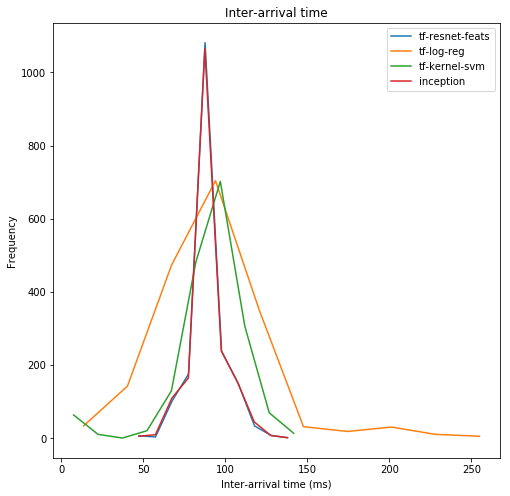

In [20]:
plot_inter_arrival(image_driver_1_500ms_all_1_unsaturated, image_driver_1_models)

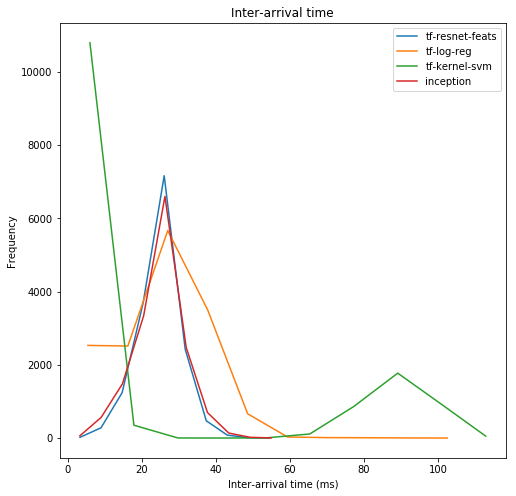

In [21]:
plot_inter_arrival(image_driver_1_500ms_all_1, image_driver_1_models)

In [168]:
svm_Q_sizes = image_driver_1_500ms_all_1["tf-kernel-svm:1:queue_sizes"]
inception_Q_sizes = image_driver_1_500ms_all_1["inception:1:queue_sizes"]
resnet_Q_sizes = image_driver_1_500ms_all_1["tf-resnet-feats:1:queue_sizes"]
logres_Q_sizes = image_driver_1_500ms_all_1["tf-log-reg:1:queue_sizes"]

def plot_queue_sizes(cached_extractions, model_list, log=False):
    plt.figure(figsize=(8,8))
    plt.title("Queue length")
    plt.xlabel("Length")
    plt.ylabel("Frequency")
    if log:
        plt.xscale("log")
    for model in model_list:
        sizes = cached_extractions[model+":1:queue_sizes"]
        plt.hist(sizes, label=model,alpha=0.3)
    plt.legend()
    
def plot_ordinal_queue_sizes(cached_extractions, model_list):
    plt.figure(figsize=(20, 5*len(model_list)))
    for i, model in enumerate(model_list):
        ax = plt.subplot(len(model_list), 1, i+1)
        sizes = cached_extractions[model+":1:queue_sizes"]
        plt.title(model+" Queue length")
        plt.xlabel("Position")
        plt.ylabel("Length")
        needlog = np.max(sizes) - np.min(sizes) > 10
        bounds = np.asarray([np.min(sizes), np.max(sizes)])
        if needlog:
            plt.yscale('symlog')
            from matplotlib.ticker import SymmetricalLogLocator
            ax.yaxis.set_major_locator(SymmetricalLogLocator(linthresh = 1, base=10.0, subs=np.arange(10)))
        ax.grid()
        plt.scatter(np.arange(len(sizes)), sizes, label=model, alpha = 0.3)

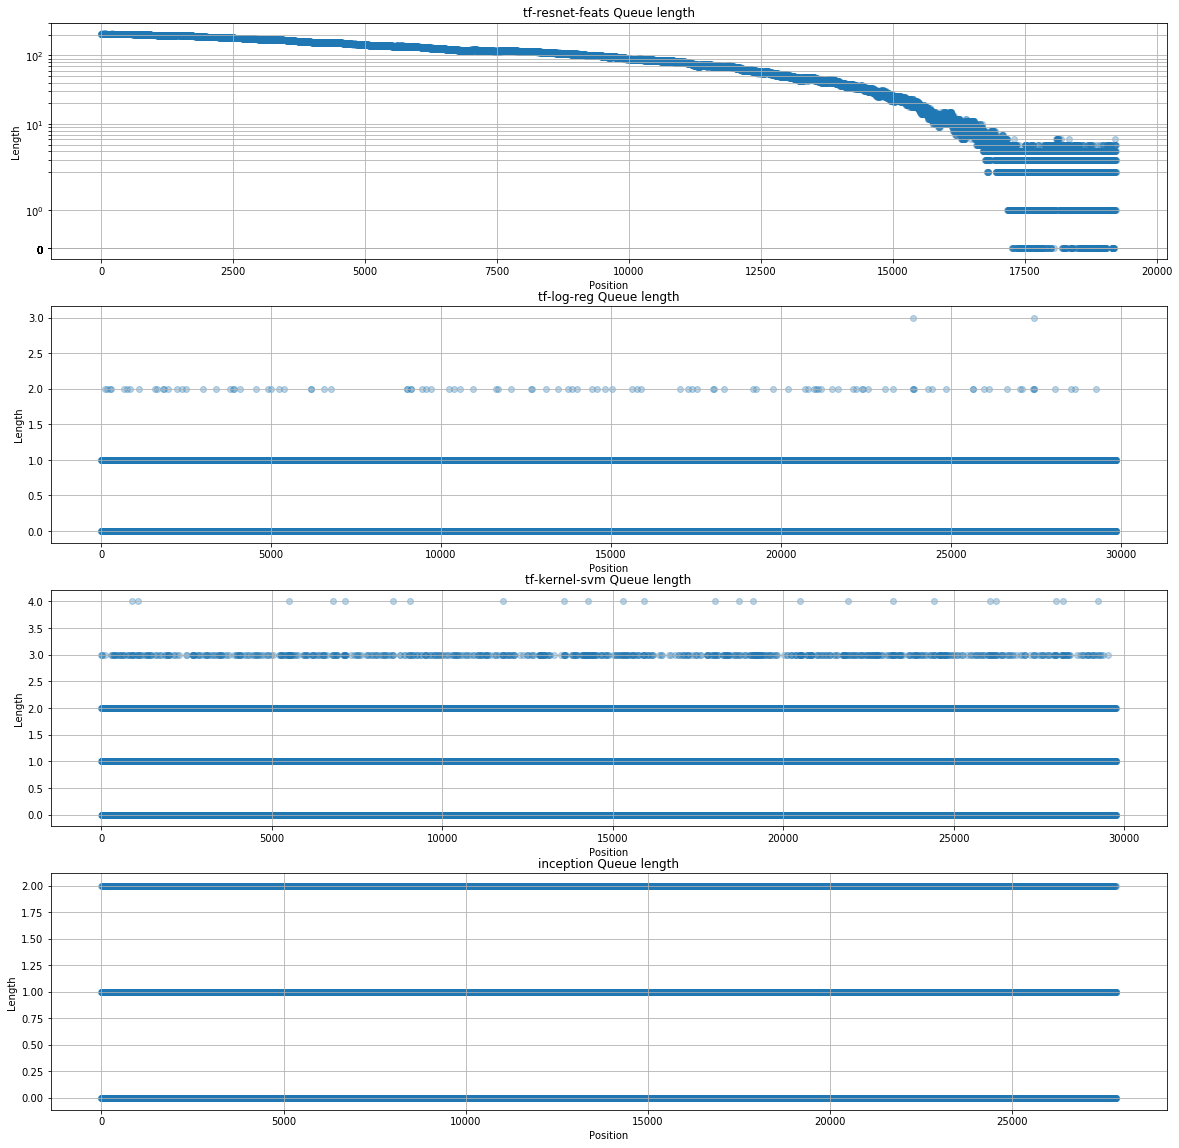

In [169]:
plot_ordinal_queue_sizes(image_driver_1_500ms_all_1, image_driver_1_models)

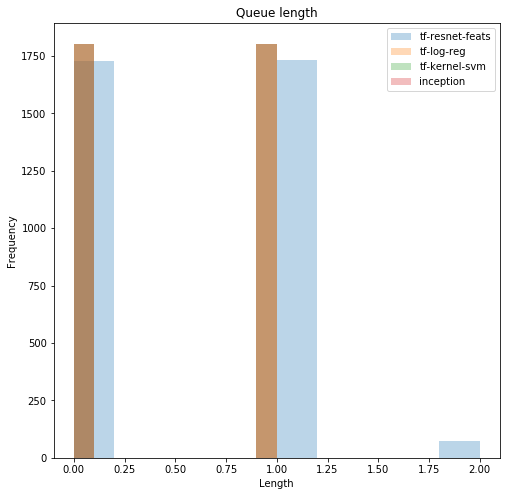

In [103]:
plot_queue_sizes(image_driver_1_500ms_all_1_unsaturated, image_driver_1_models)

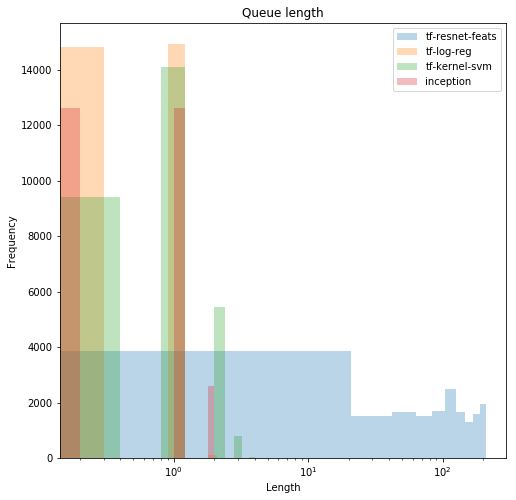

In [104]:
plot_queue_sizes(image_driver_1_500ms_all_1, image_driver_1_models, log=True)

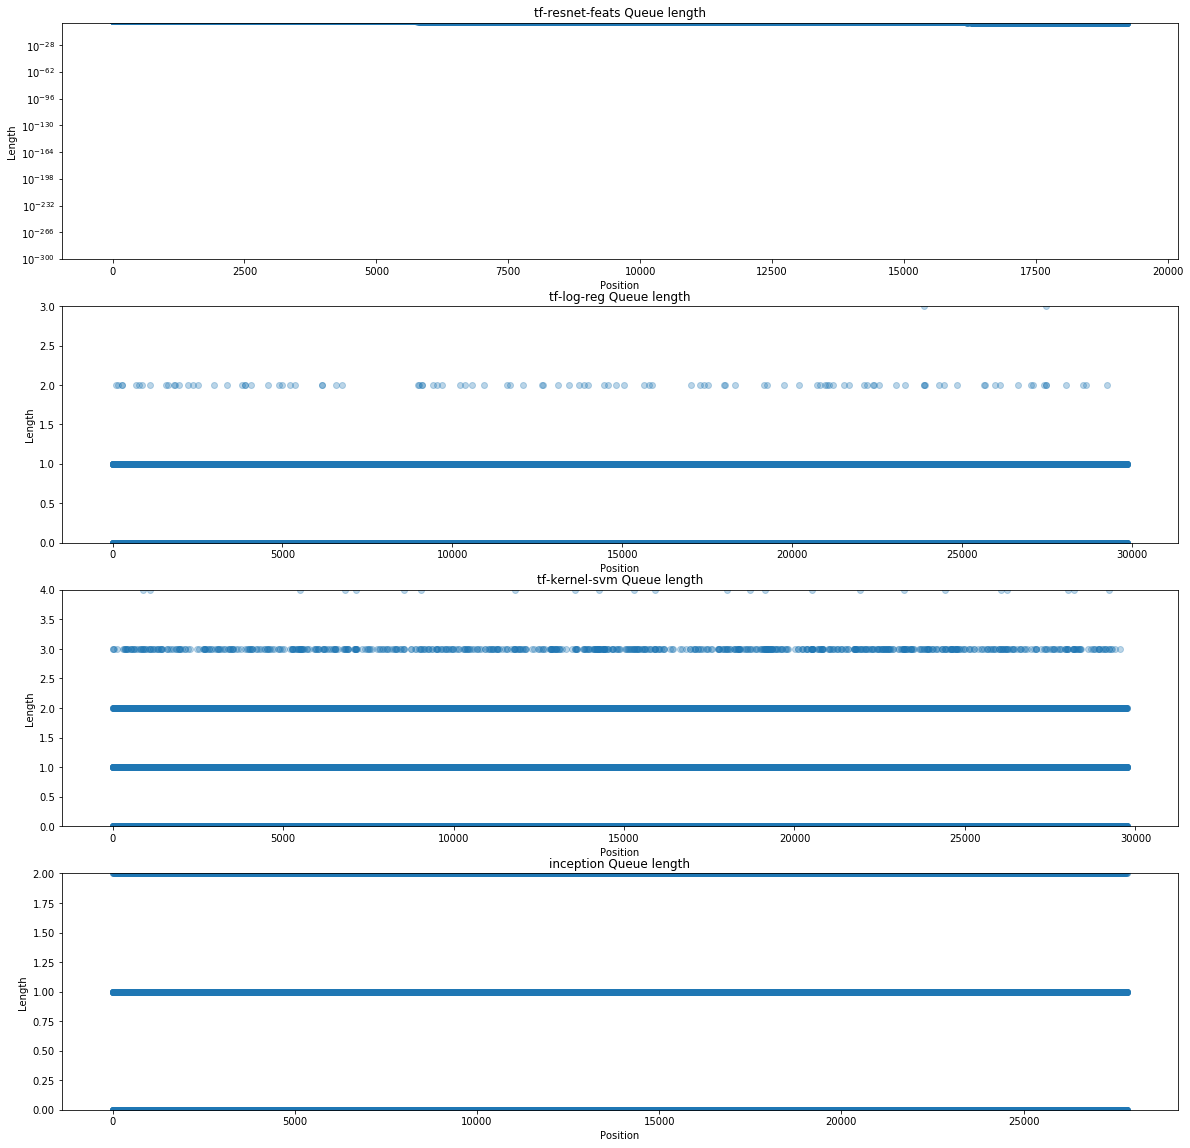

In [105]:
plot_ordinal_queue_sizes(image_driver_1_500ms_all_1, image_driver_1_models)

In [29]:
image_driver_1_500ms_all_1["tf-resnet-feats:1:queue_sizes"]

array([ 208.,  209.,  205., ...,    1.,    2.,    3.])

In [26]:
def plot_e2e_lats(cached_extractions):
    plt.figure(figsize=(8,8))
    plt.title("e2e Latencies")
    lineHistogram(cached_extractions["e2e_lats"])
    plt.xlabel("Latency (seconds)")
    plt.ylabel("Frequency")

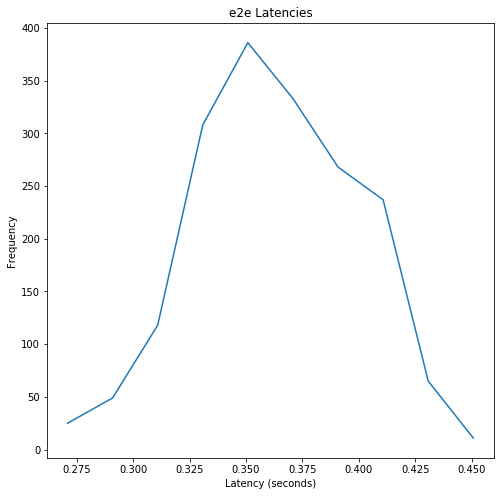

In [27]:
plot_e2e_lats(image_driver_1_500ms_all_1_unsaturated)

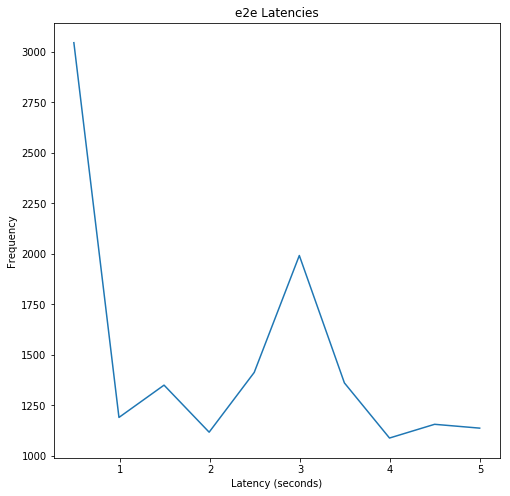

In [28]:
plot_e2e_lats(image_driver_1_500ms_all_1)